<a href="https://colab.research.google.com/github/sjsu-cs133-f25/team5-climatechange-trends/blob/main/notebooks/03_structure.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Climate Change Dataset Pattern Discovery

### Discovery plan

- **Goal**: Identify structural patterns within the global warming dataset, such as correlated variable blocks, latent dimensions, or natural clusters among countries.
- **Hypothesis:** We expect to find strong correlation between greenhouse gas emissions, industrial activity, and fossil fuel use; and potentially inverse relations with forest area or renewable energy use.
- **Why it matters:** Revealing these structures helps policy makers target leverage points (such as high-emission economies or correlated environmental indicators).

# Data Card


Dataset source & link, shape (rows/cols), units, time coverage:
*   Dataset source: Global Warming Dataset: 195 Countries (1900-2023)
*   Dataset link: https://www.kaggle.com/datasets/ankushpanday1/global-warming-dataset-195-countries-1900-2023
*   shape: 100,000 rows and 26 columns
*   units: numerical, categorical
*   time coverage: 1900-2023


Column dictionary (human-readable; short), key ID columns, target(s) if any:
*   shape: 100,000 rows and 26 columns

      * Country - the country identifier
      * Year - the year, from 1900-2023
      * Temperature_Anomoly - difference in temperature from baseline, in °C
      * CO2_Emissions - total CO2 emissions, in metric tons
      * Population - number of people in the country
      * Forest Area - area of forest cover, in % of land area
      * GDP - Gross Domestic Product, in USD
      * Renewable_Energy_Usage - total energy derived from renewable energy sources, in %
      * Methane_Emissions - total methane emissions, in metric tons CO2 equivalent
      * Sea_Level_Rise - change in sea level, in mm
      * Arctic_Ice_Extent - area covered by arctic ice, in million km²
      * Urbanization - population living in urban areas, in %
      * Deforestation_Rate - loss of forest area, in %
      * Extreme_Weather_Events - count of extreme events that occurred
      * Average_Rainfall - average precipitation, in mm
      * Solar_Energy_Potential - potential for solar energy, in kWh/m²
      * Waste_Management - score of the country's waste management practices, in %
      * Per_Capita_Emissions - total greenhouse gases emissions per capita, in tons / person
      * Industrial_Activity - industrial output or production, in %
      * Air_Pollution_Index - air quality index, from 0-300
      * Biodiversity_Index - measures the variety of species, in %
      * Ocean_Acidification - pH level of ocean
      * Fossil_Fuel_Usage - total energy consumption from fossil fuels, in %
      * Energy_Consumption_Per_Capita - energy usage per person
      * Policy_Score - the country's climate policy performance score, from 0-100
      * Average_Temperature - average temperature, in °C



Missingness snapshot: which columns have NaNs and rough %:
*   NaNs: 14 missing values found


Known quirks (e.g., mixed types, inconsistent labels):
*    the meaning of the values for some of the columns, such as the policy score, and the units for some are ambiguous
*    The countries column did not specify the names of the actual countries and instead labeled countries numerically


### Load

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import kagglehub

# download dataset
path = kagglehub.dataset_download("ankushpanday1/global-warming-dataset-195-countries-1900-2023")

# read csv file
df = pd.read_csv(path + "/global_warming_dataset.csv")

100%|██████████| 20.5M/20.5M [00:01<00:00, 19.7MB/s]

Extracting files...


### Prep

In [2]:
# 1 Remove spaces
df = df.rename(columns=lambda c: c.strip().replace(" ", "_"))

# 2 Convert to numeric
df["Year"] = pd.to_numeric(df["Year"], errors="coerce").astype("Int64")
df["Country"] = df["Country"].astype("category")

num_cols = df.columns.difference(["Country", "Year"])
df[num_cols] = df[num_cols].apply(pd.to_numeric, errors="coerce")

# 3 Handle missing values
df[num_cols] = df[num_cols].fillna(df[num_cols].median())

# 4 Group by Country, Year
df = df.groupby(["Country", "Year"], as_index=False, observed=False).mean(numeric_only=True)

print("Missing Values:", df.isna().any().sum())
print("Duplicates:", df.duplicated().sum())

Missing Values: 24
Duplicates: 0


### Transforms

In [3]:
# Make categories ordered for nicer sorting/plots.
gdp_order = pd.CategoricalDtype(
    categories=["Low Income", "Lower-Middle Income", "Upper-Middle Income", "High Income"],
    ordered=True
)

cat_order = pd.CategoricalDtype(
    categories=["Low", "Medium", "High"],
    ordered=True
)

# Temperature increase flag
df["Temp_Increased"] = df["Temperature_Anomaly"] > 0

# Air Quality Category
def pollution_category(x):
    if x > 200:     return "Very Unhealthy"
    elif x > 150:   return "Unhealthy"
    elif x > 100:   return "Unhealthy (Sensitive)"
    elif x > 50:    return "Moderate"
    else:           return "Good"
df["Air_Quality_Category"] = df["Air_Pollution_Index"].map(pollution_category)

# GDP per capita and Income group
df["GDP_per_capita"] = df["GDP"] / df["Population"]

def gdp_category(x):
    if x >= 13846:  return "High Income"
    elif x >= 4466: return "Upper-Middle Income"
    elif x >= 1136: return "Lower-Middle Income"
    else:           return "Low Income"
df["GDP_Income_Group"] = df["GDP_per_capita"].map(gdp_category).astype(gdp_order)

# CO2 per capita
df["CO2_per_capita"] = df["CO2_Emissions"] / df["Population"]

# Renewable Energy Usage Groups
def renewable_group(x):
    if x >= 50:     return "High"
    elif x >= 20:   return "Medium"
    else:           return "Low"
df["Renewable_Group"] = df["Renewable_Energy_Usage"].apply(renewable_group).astype("category")

# Industrial Activity Groups
def industrial_activity_group(x):
    if x >= 80:     return "High"
    elif x < 80 & x >= 40:   return "Medium"
    else:           return "Low"
df['Industrial_Activity_Group'] = df.Industrial_Activity.map(renewable_group).astype(cat_order)

# Decades
def get_decade(year):
  decade = year // 10
  decade_str = str(decade * 10) + "'s"
  return decade_str

df['Decade'] = df.Year.map(get_decade)

# Log versions for heavy-tailed per-capita vars (for clearer structure)
df["log_CO2_per_capita"] = np.log1p(df["CO2_per_capita"])
df["log_GDP_per_capita"] = np.log1p(df["GDP_per_capita"])


### Structure Figures

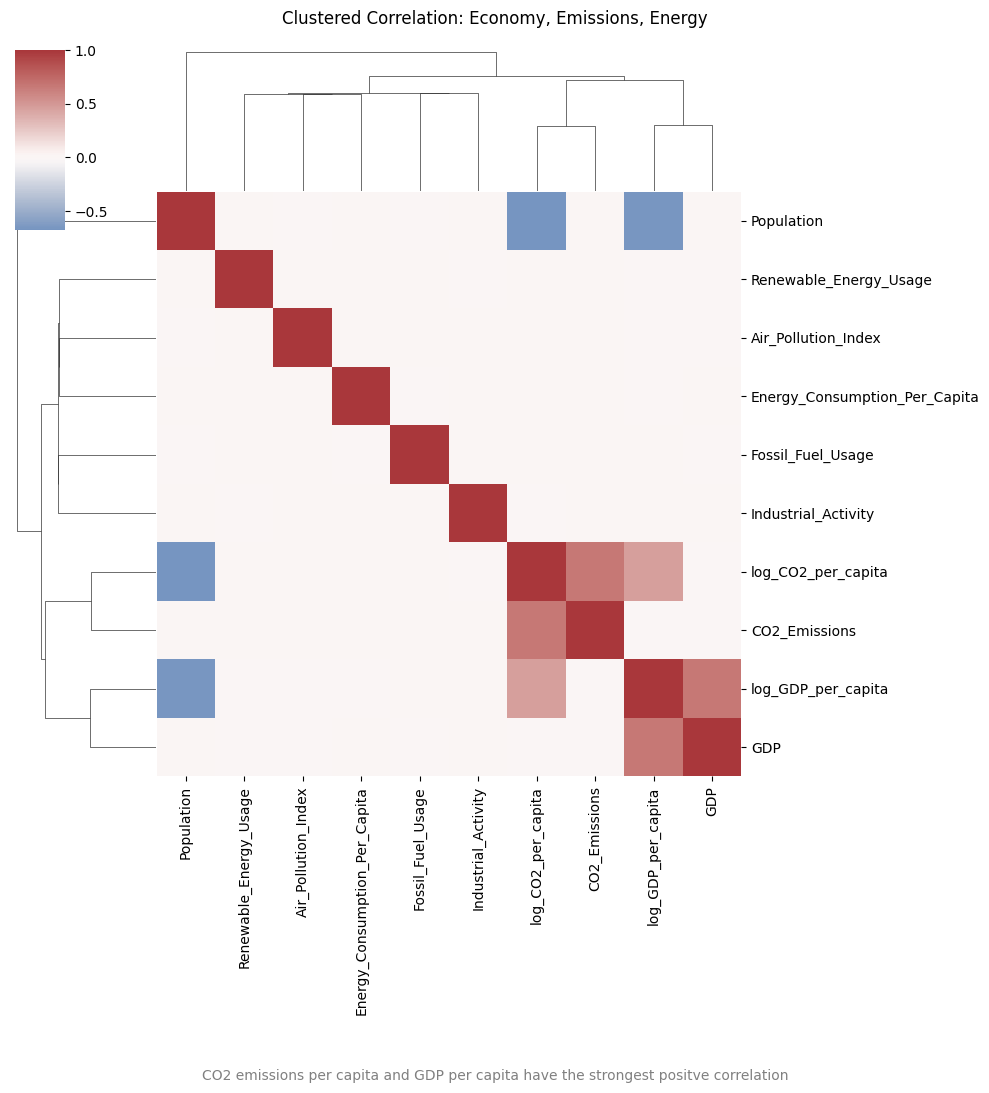

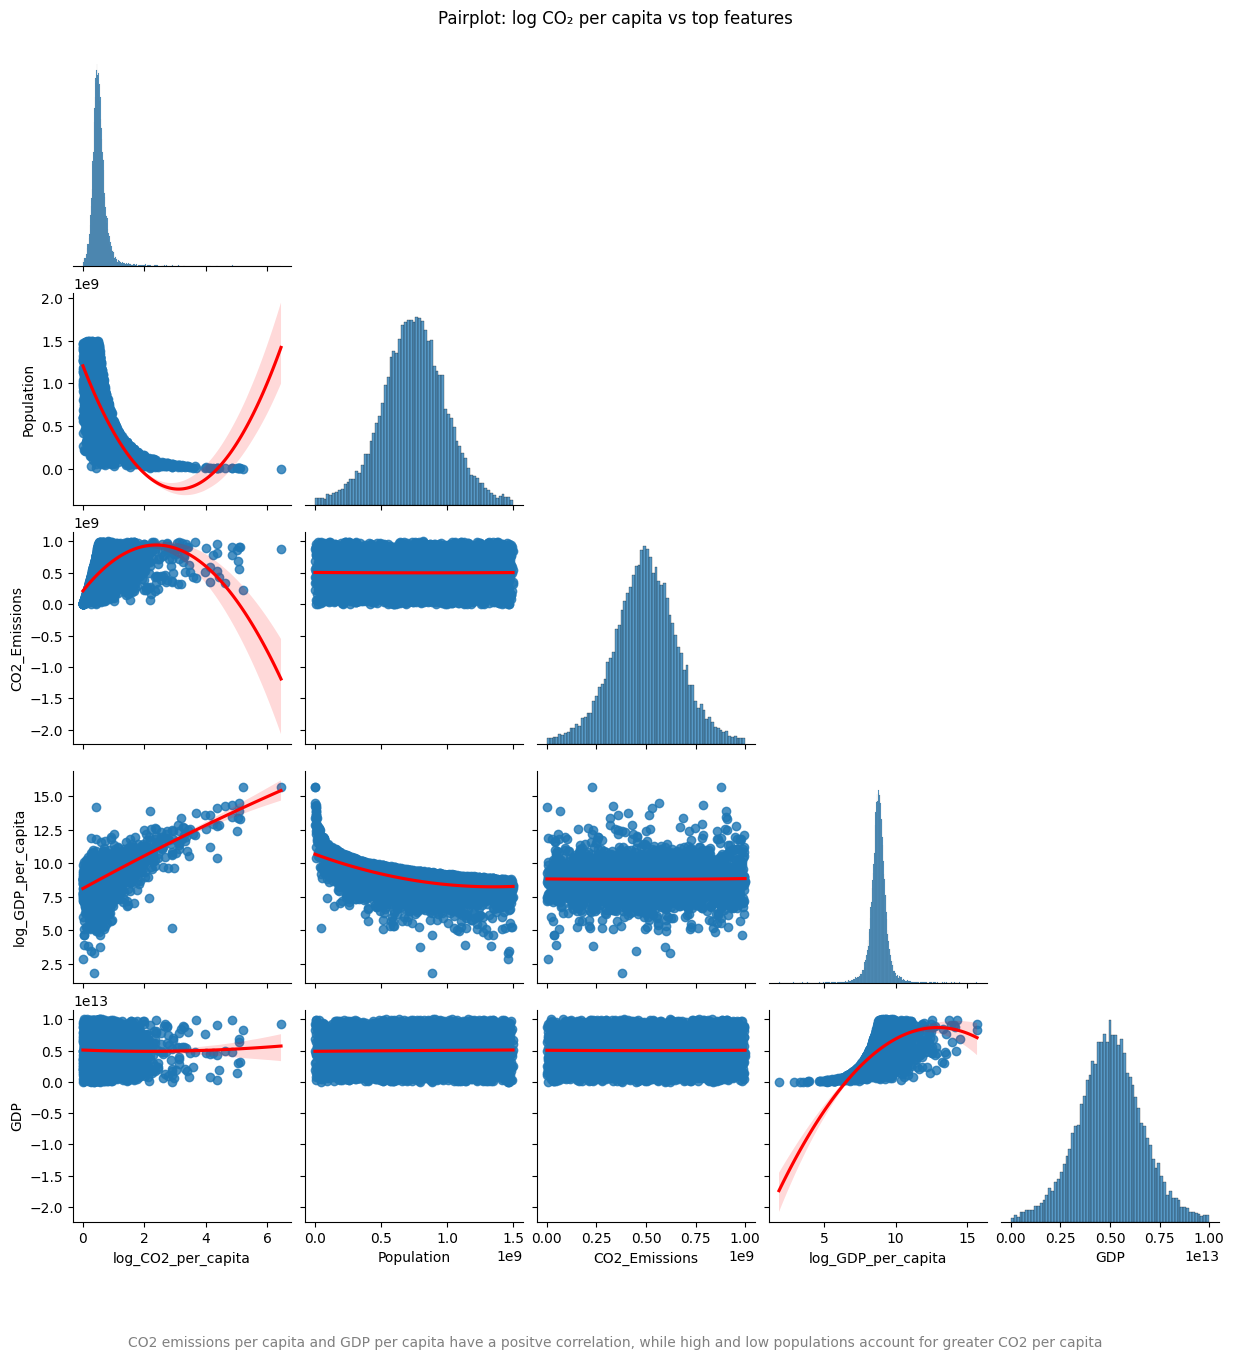

In [4]:
cols = ["log_CO2_per_capita","log_GDP_per_capita","CO2_Emissions","GDP","Population",
        "Air_Pollution_Index","Renewable_Energy_Usage","Fossil_Fuel_Usage",
        "Energy_Consumption_Per_Capita","Industrial_Activity"]

Z = df[cols].replace([np.inf, -np.inf], np.nan).dropna()
corr = Z.corr("spearman")

# Clustered Correlation
g = sns.clustermap(corr, cmap="vlag", center=0)
g.figure.suptitle("Clustered Correlation: Economy, Emissions, Energy", y=1.02)
caption_text = "CO2 emissions per capita and GDP per capita have the strongest positve correlation"
plt.figtext(0.5, -0.05, caption_text, wrap=True, ha='center', fontsize=10, color='gray')
plt.show()

# Pairplot
top = corr["log_CO2_per_capita"].abs().nlargest(5).index
sns.pairplot(Z[top], kind="reg", corner=True, plot_kws={"order":2, "line_kws":{"color":"red"}})
plt.suptitle("Pairplot: log CO₂ per capita vs top features", y=1.02)
caption_text = "CO2 emissions per capita and GDP per capita have a positve correlation, while high and low populations account for greater CO2 per capita"
plt.figtext(0.5, -0.05, caption_text, wrap=True, ha='center', fontsize=10, color='gray')
plt.show()

### Calculations

In [5]:
r2 = corr**2
mean_r2 = r2.where(~np.eye(len(r2), dtype=bool)).stack().mean()
print(f"Mean R^2: {mean_r2}")

r2_pair = r2.loc["log_CO2_per_capita", "log_GDP_per_capita"]
print(f"R^2 (log_CO2_pc vs log_GDP_pc): {r2_pair}")

Mean R^2: 0.04501632230717477
R^2 (log_CO2_pc vs log_GDP_pc): 0.21822068223096


### Findings

Overall feature relationships are weak (mean R² < 0.05), but log GDP per capita explains about 22 % of the variance in log CO2 per capita, showing a clear economic–emissions correlation.